In [1]:
import mujoco
import mediapy as media

""

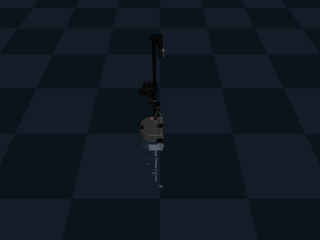

In [2]:
# PATHS
HR_MODEL_PATH = "stretch2//stretch.xml"
hr_model = mujoco.MjModel.from_xml_path(HR_MODEL_PATH)
hr_data = mujoco.MjData(hr_model)
hr_renderer = mujoco.Renderer(hr_model)
mujoco.mj_forward(hr_model, hr_data)
hr_renderer.update_scene(hr_data)
media.show_image(hr_renderer.render())
duration = 3
fps = 60
frames = []
camera_frames = []

mujoco.mj_resetData(hr_model, hr_data)
hr_data.ctrl[0] = 10
hr_data.ctrl[7] = -2
hr_data.ctrl[6] = 1
scene_option = mujoco.MjvOption()
scene_option.flags[mujoco.mjtVisFlag.mjVIS_JOINT] = False
while hr_data.time < duration:
	mujoco.mj_step(hr_model, hr_data)
	if len(frames) < hr_data.time * fps:
		hr_renderer.update_scene(hr_data, camera='camera_rgb')
		cam_pixels = hr_renderer.render()
		camera_frames.append(cam_pixels)
media.show_video(camera_frames, fps=fps)


""

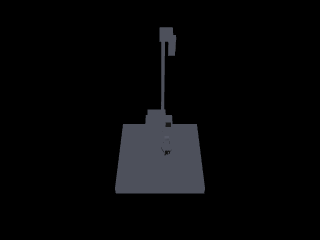

In [4]:
HR_URDF_PATH = 'SE3/stretch_description_SE3_eoa_wrist_dw3_tool_sg3.xml'
hr_model = mujoco.MjModel.from_xml_path(HR_URDF_PATH)
hr_data = mujoco.MjData(hr_model)
hr_renderer = mujoco.Renderer(hr_model)
mujoco.mj_forward(hr_model, hr_data)
hr_renderer.update_scene(hr_data)
media.show_image(hr_renderer.render())
duration = 3
fps = 60
frames = []
camera_frames = []

mujoco.mj_resetData(hr_model, hr_data)
# hr_data.ctrl[0] = 10
# hr_data.ctrl[7] = -2
# hr_data.ctrl[6] = 1
scene_option = mujoco.MjvOption()
scene_option.flags[mujoco.mjtVisFlag.mjVIS_JOINT] = False
while hr_data.time < duration:
	mujoco.mj_step(hr_model, hr_data)
	if len(frames) < hr_data.time * fps:
		hr_renderer.update_scene(hr_data)
		cam_pixels = hr_renderer.render()
		camera_frames.append(cam_pixels)
media.show_video(camera_frames, fps=fps)
